# Travel Times in 1D Models

## Name:

## Date: 

In [1]:
# If using Anaconda3 on your machine you can do without this.  This is for Azure people.
#!pip install obspy # TODO Uncomment if on Azure

## Computing the $X$ offset and travel time $T$ of the downgoing ray in a linear velocity gradient

To begin, recall that the offset, $X$, and travel time $T$ of the down-going ray path in $1D$ media is very generally given by 
\begin{equation}
  x(p) = \int_0^{h} \frac{p v(h)}{\sqrt{1 - p^2 v^2(h)}} dh
\end{equation}
\begin{equation}
  t(p) = \int_0^{h} \frac{1}{v(h) \sqrt{1 - p^2 v^2(h)}} dh
\end{equation}
where $h$ is the thickness of the model, $v$ the velocity, and $p$ the ray parameter.  We now introduce the velocity gradient
\begin{equation}
  v = v(h) = v_0 + a h
\end{equation}
where $v_0$ is the velocity at $h=0$ and $a$ the velocity gradient.  Inserting the velocity gradient into the offset and travel time equations
\begin{equation}
  x(p) = \int_0^{h} \frac{p (v_0 + ah)}{\sqrt{1 - p^2(v_0 + ah)^2}} dh
\end{equation}
\begin{equation}
  t(p) = \int_0^{h} \frac{1}{(v_0 + a h) \sqrt{1 - p^2 (v_0 + ah)^2} } dh
\end{equation}
Let's now change the integrals to be functions of $v$.  To do this we use the change of variables $v = v_0 + a h$.  The derivative requires that $dv = a dh$ or
\begin{equation}
  dh = \frac{dv}{a} 
\end{equation}
The limits of the integrands must also be reworked so that 
\begin{equation}
  v(h=0) = v_0
\end{equation}
and
\begin{equation}
  v(h=h) = v_0 + \frac{(v_1 - v_0)}{h} h = v_1
\end{equation}
the offset and travel time integrals are then transformed into 
\begin{equation}
  x(p) = \frac{1}{a} \int_{v_0}^{v_1} \frac{pv}{\sqrt{1 - p^2 v^2}} dv
\end{equation}
\begin{equation}
  t(p) = \frac{1}{a} \int_{v_0}^{v_1} \frac{1}{v \sqrt{1 - p^2 v^2} } dv
\end{equation}
The first integral has, for this entire time, corresponded to a fairly obvious u substitution.  The second integral is less obviously the inverse hyperbolic cos.  Let's make the mechanics of both integrals a little more clear by making one more substitution, $s = pv$.  This requires that 
\begin{equation}
  dv = \frac{ds}{p}
\end{equation}
and new integral limits $s_1 = pv_0$ and $s_2 = pv_1$.  
\begin{equation}
  x(p) = \frac{1}{a} \int_{pv_0}^{pv_1} \frac{s}{\sqrt{1 - s^2}} \frac{ds}{p}
       = \frac{1}{a p} \int_{pv_0}^{pv_1} \frac{s}{\sqrt{1 - s^2}} ds
\end{equation}
\begin{equation}
  t(p) = \frac{1}{a} \int_{pv_0}^{pv_1} \frac{p}{s \sqrt{1 - s^2} } \frac{ds}{p}
       = \frac{1}{a} \int_{pv_0}^{pv_1} \frac{1}{s \sqrt{1 - s^2} } ds
\end{equation}
The first integral is 
\begin{equation}
  x(p) =-\frac{1}{ap} \left . \sqrt{1 - s^2} \right |_{p v_0}^{p v_1}
       = \frac{1}{ap} \left . \sqrt{1 - s^2} \right |_{p v_1}^{p v_0}
       = \frac{1}{ap} \left . \sqrt{1 - v^2 p^2} \right |_{v_1}^{v_0}
       = \frac{v}{a p} \left . \sqrt{\frac{1}{v^2} - p^2} \right |_{v_1}^{v_0}
\end{equation}
The second integral is a little more complicated so I'll write down the punchline.  
<!--
In this case, you would say that $u=\sqrt{1 - s^2}$.  Thus, $du =-\frac{s}{\sqrt{1 - s^2}} ds$ or $\frac{ds}{\sqrt{1 - s^2}} =-\frac{du}{s}$.  
\begin{equation}
  t(p) =-\frac{1}{a} \int \frac{du}{s^2} 
       =-\frac{1}{a} \int \frac{du}{1 - u^2}
       = \frac{1}{a} \int \frac{du}{u^2 - 1}
       = \frac{1}{a} \int \frac{1}{1 - u} - \frac{1}{u + 1} \, du
       = \frac{1}{a} \left [ \log(1 - u) - \log(u + 1) \right ]
       = \frac{1}{a} \left [ \log(1 - \sqrt{1-s^2}) - \log(\sqrt{1-s^2} + 1)  \right ]
       = \frac{1}{a} \left [ \frac{1 - \sqrt{1 - s^2}}{\sqrt{1 - s^2} + 1} \right ]
\end{equation}
-->
\begin{equation}
  t(p) =-\frac{1}{a} \log \left ( \frac{1 + \sqrt{1 - s^2}}{s} \right )_{p v_0}^{p v_1}
       = \frac{1}{a} \log \left ( \frac{1 + \sqrt{1 - p^2 v^2}}{p v} \right )_{v_1}^{v_0}
       = \frac{1}{a} \log \left ( \frac{1}{vp} +  \frac{1}{p} \sqrt{ \frac{1}{v^2} - p^2 } \right )_{v_1}^{v_0}
\end{equation}
Defining the vertical slowness $\eta = \sqrt{\frac{1}{v^2} - p^2}$ and $u=\frac{1}{v}$ we have that the offset is simply given by
\begin{equation}
  x(p) = \left . \frac{1}{a u p} \eta \right |_{u_1}^{u_0}
\end{equation} 
\begin{equation}
  t(p) = \frac{1}{a} \log \left ( \frac{u + \eta}{p} \right )_{v_1}^{v_0}
\end{equation}
You would think that here Shearer calls it a day.  But no.  Let's further add by zero so that
\begin{equation}
  t(p) = \frac{1}{a} \log \left ( \frac{u + \eta}{p} \right )_{v_1}^{v_0}
       - p \left . \frac{1}{a u p} \eta \right |_{u_1}^{u_0}
       + p \left . \frac{1}{a u p} \eta \right |_{u_1}^{u_0}
       = \frac{1}{a} \left (  \log \left ( \frac{u + \eta}{p} \right ) - \frac{\eta}{u} \right )_{v_1}^{v_0}
       + p x(p)
\end{equation}
## What Needs to be Programmed
And there you have it - the equations to implement for computing offset and travel time are
\begin{equation}
  x(p) = \left . \frac{1}{a u p} \eta \right |_{u_1}^{u_0}
\end{equation}
\begin{equation}
  t(p) = \frac{1}{a} \left (  \log \left ( \frac{u + \eta}{p} \right ) - \frac{\eta}{u} \right )_{v_1}^{v_0}
       + p x(p)
\end{equation}
In general we have to be somewhat careful.  For example, if the slowness becomes undefined at the bottom of the layer we would say the ray has turned and only keep the first contribution.  Additionally, we are not counting the upgoing contribution, thus, $x(p)$ would have to be multiplied by $2$ to obtain $X(p)$.



## Additional Notes 

The cleanest derivations I've seen for the the linear gradient problem are from Slotnick's Lessons in Seismic Computing and Sergey Fomel's 2008 paper - Fast sweeping method for the factored eikonal equation.  I ultimately used Slotnick's derivation because it is simpler but working from the ray-path equation defined as a first order system does open more potential doors.  I've tried to rework Slotnick's work to match the results given in the Shearer's textbook.



<!---

If you want to have a go then uncomment the lines in this cell
$$
\cosh^{-1}(x) = \ln(x + \sqrt{x^2 -1})
$$
$$
\int \frac{1}{\sqrt{x^2 - 1}}
$$
$$
\ln \left ( \frac{1}{v(z)} + \sqrt{\frac{1}{v(z)^2} - p^2} \right ) 
- \frac{1}{v(z)} \sqrt{\frac{1}{v(z)^2} - p^2} - \ln(p)
$$
Using Wolfram this is really close to the integral of 
$$
I=\int \sqrt{x^2 - p^2} dx =-\frac{p^2}{2} \ln(x^2 - p^2) + x\sqrt{x^2 - p^2} + constant
$$
which would be great because I can write 
$$
t(p) = px(p) + \int \sqrt{\gamma(z)^2 - p^2} dz
$$
anyway...
$$
\ln \left ( x + \sqrt{x^2 - 1} \right ) 
-\frac{p}{v(z)} \sqrt{\frac{1}{p^2 v(z)^2} - 1}
$$
$$
\ln \left ( x + \sqrt{x^2 - 1} \right ) 
-\frac{p^2}{v(z)} \sqrt{\frac{1}{p^2 v(z)} - 1}
$$
$$
t(x) = \ln \left ( x + \sqrt{x^2 - 1} \right ) - p^2 x \sqrt{x^2 - 1}
$$
Differentiate and get
$$
  \frac{dt}{dx}
 =\frac{1}{\sqrt{x^2 - 1}} \frac{dx}{dv} \frac{dv}{dz}
- p^2 \sqrt{x^2 - 1} \frac{dx}{dv} \frac{dv}{dz}
- p^2 x^2 \frac{1}{\sqrt{x^2 - 1}} \frac{dx}{dv} \frac{dv}{dz}
$$
$$
\frac{1 - p^2 x^2}{\sqrt{x^2 - 1}} \frac{dx}{dz}  - p^2 \sqrt{x^2 - 1} \frac{dx}{dz} 
$$
$$
\frac{1 - p^2 x^2}{\sqrt{x^2 - 1}} \frac{dx}{dz}  - \frac{p^2 (x^2 - 1)}{\sqrt{x^2 - 1}} \frac{dx}{dz} 
$$
$$
\frac{1 + p^2(1 - 2 x^2)}{\sqrt{x^2 - 1}} \frac{dx}{dz} 
$$
Maybe this is the time to evaluate $\frac{dv}{dz} = b$ and $\frac{dx}{dv} =-\frac{1}{p v(z)^2}$ so 
that
$$
  \frac{dx}{dv} \frac{dv}{dz} =-\frac{b}{p v(z)^2}
$$
And
$$
 -\frac{1 + p^2(1 - 2 x^2)}{\sqrt{\frac{1}{pv(z)^2} - 1}} \frac{b}{p v(z)^2}
=-\frac{b + b p^2 \left (1 - 2 \frac{1}{p^2 v(z)^2} \right )}{v(z) \sqrt{1 - v(z)^2 p^2}}  
=-\frac{b(1 + p^2)  - 2 \frac{1}{v(z)^2} }{v(z) \sqrt{1 - v(z)^2 p^2}}  
$$
--->


In [2]:
from numpy import sqrt
from numpy import log
from numpy import linspace
from numpy import zeros
from numpy import asarray

def layerxt(p, h, vtop, vbottom):
    """
    Calcualtes the change in position and change in time for a ray in a layer with a linear
    velocity gradient.  This is a Python translation of Shearer's layerxt which was heavily
    modified from a portion of Chris Chapman's WKBJ program.
    
    Input
    -----
    p : float
        Horizontal slowness (s/km).
    h : float
        Layer thickness (km).
    vtop : float
        Velocity (km/s) at the top of the layer.
    vbottom : float
        Velocity (km/s) at the bottom of the layer.
        
    Returns
    -------
    dx : float
         Range offset (km).
    dt : float
         Travel time change (seconds).    
    irtr : integer
        This is a return code that can mean:
          -1 -> zero thickness layer.
           0 -> ray turned above the layer.
           1 -> ray passed through the layer.
           2 -> ray turned in the layer and only one leg in the dx and dt is counted.
    
    """
    # Checks
    irtr =-1
    dx = None
    dt = None
    if (h < 0.0):
        print("Layer thickness cannot be negative")
        return dx, dt, irtr
    if (vtop <= 0.0 or vbottom <= 0.0):
        print("Velocities must be positive")
        return dx, dt, irtr
    # Compute slownesses
    u1 = 1.0/vtop    # Slowness at top of layer
    u2 = 1.0/vbottom # Slowness at bottom of layer
    dx = 0.0
    dt = 0.0
    # Ray turned above this layer
    if (p >= u1):
        irtr = 0
        return dx, dt, irtr
    # Zero layer thickness
    if (h == 0):
        irtr = -1
        return dx, dt, irtr
    b = (vtop - vbottom)/h # Velocity gradient; Eqn 4.20 of Shearer
    eta1 = sqrt(u1**2 - p**2)

    # Constant velocity layer - ray must pass through
    if (abs(b) == 0.0):
        dx = h*p/eta1
        dt = h*u1**2/eta1
        irtr = 1
        return dx, dt, irtr
    
    x1 = eta1/(u1*b*p) # Eqn 4.21 of Shearer
    tau1 = (log((u1 + eta1)/p) - eta1/u1)/b # Eqn 4.22 of Shearer
    # Ray turns within layer - no contribution to integral from bottom point
    # Ray turned in the layer
    if (p >= u2):
        dx = x1
        dtau = tau1
        dt = dtau + p*dx
        irtr = 2
        return dx, dt, irtr

    # Ray passed through the layer
    irtr = 1
    eta2 = sqrt(u2**2 - p**2)
    x2 = eta2/(u2*b*p) # Eqn 4.21 of Shearer
    tau2 = (log((u2 + eta2)/p) - eta2/u2)/b # Eqn 4.22 of Shearer

    dx = x1 - x2
    dtau = tau1 - tau2

    dt = dtau + p*dx
    
    return dx, dt, irtr


In [3]:
def computeXTInLayeredGradientModel(rayParameters, deps, vp, redvel = 8.0):
    """
    Computes the travel-time distance in a layered model where each model
    consists of velocity gradients.  Here, the structural models increase
    positively with depth.
    
    Input
    -----
    rayParameters : array_like
        Apparent slownesses (s/km)
    deps : array_like
        Depth to each interface (km).  Note, there are len(h) - 1 layers and each
        layer thickness is h[layer+1] - h[layer].  
    vp : array_like
        Compressional velocity (km/s) at the layer interfaces.
    redvel : float
        Reduction velocity (km/s).  Shearer uses 8 km/s in the HW.
    
    Returns
    -------
    offset : array_like
        The offsets in x (km), i.e, distance traveled for each ray parameter.
    ttimes : array_like
        The redued travel times (s) for each ray parameter.
    
    Copyright
    ---------
    Ben Baker distributed under the MIT license.
    
    """
    # Loop on ray parameters
    xtimes = zeros(len(rayParameters))
    ttimes = zeros(len(rayParameters))
    for ip in range(len(rayParameters)):
        # Loop on model depths
        x = 0.0 # Offset
        t = 0.0 # Travel time
        p = rayParameters[ip] # Ray parameter
        for depth in range(len(deps)-1):
            h = deps[depth+1] - deps[depth]
            vtop    = vp[depth]
            vbottom = vp[depth+1]
            dx, dt, irtr = layerxt(p, h, vtop, vbottom)
            # Typically the ray continues through the layer
            if (irtr == 1):
                x = x + dx*2.0 # Up and downgoing leg
                t = t + dt*2.0 # Up and downgoing leg
            elif (irtr == 2):
                x = x + dx*2.0 # Up and downgoing leg
                t = t + dt*2.0 # Up and downgoing leg
                break
            # Ray turned in layer above - stop calculating (I should hit this)
            if (irtr == 0):
                break
        # Loop on depths
        xtimes[ip] = x # Tabulate distance
        ttimes[ip] = t # Tabulate time
    # Loop on ray parameters
    #TODO - Something screwy - but x and t are negative.  I need to implement from Chapman's book
    offset =-xtimes # Make xtimes positive
    ttimes =-ttimes
    if (redvel > 0.0):
        reducedTimes = ttimes - offset/redvel # Reduce travel times with reduction velocity
    else:
        reducedTimes = ttimes
    return offset, reducedTimes


## Programming Question - Shearer Question 8 From Section 4.11

Compute the P-wave traveltime, $T(X)$ curve for the velocity model

| Depth (km)  | $\alpha$ (km/s) | $\beta$ (km/s)  | $\rho$ (g/cm^3) |
| ----------- |-------------:| -----:|----:|
| 0.0         | 4.50         | 2.40  | 2.0 |
| 1.5         | 6.80         | 3.75  | 2.8 |
| 6.0         | 7.00         | 3.85  | 2.9 |
| 6.5         | 8.00         | 4.60  | 3.1 |
| 10.0        | 8.10         | 4.70  | 3.1 |

for $100$ ray parameters from $0.1236$ s/km to $0.2217$ s/km.  Use a reduction velocity of $8$ km/s.

As a hint, your function call should look something like:

    offset, ttimes = computeXTInLayeredGradientModel(rayParameters, deps, velocities, redvel)

You'll probably want to program something like:

    deps = [0.0, 1.5,  6.0,  6.5, 10.0] # Layer interfaces
    vs   = [2.4, 3.75, 3.85, 4.6, 4.7]  # Shear velocity (km/s) - THIS IS OF NO USE TO YOU - CHANGE TO VP
    redvel = 8.0  # Reduction velocity (km/s).  This trick increases the resolution of the curve.
    pmin = 0.1236 # Minimum slowness in x (s/km)
    pmax = 0.2217 # Maximum slowness in x (s/km)
    np = 100 # Number of ray parameters
    rayParameters = linspace(pmin, pmax, np)
    offset, ttimes = computeXTInLayeredGradientModel(rayParameters, deps, vp, redvel)

## Insert Your Code Here

In [14]:
# Put your code here


## Question

Caustics are where $\frac{dp}{dx} = \infty$.  Given this, plot a travel-time vs. offset curve from distance $0$ to $\max\{offset\}$ and identify the offsets at which the caustics are located.  Be sure to fix the code so that your axes are correctly labeled.


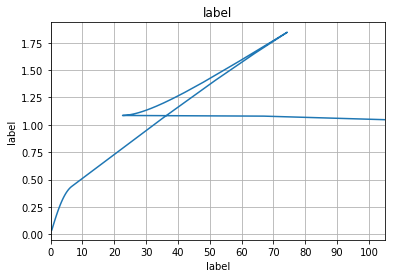

In [5]:
import matplotlib.pyplot as plt
plt.plot(offset, ttimes) # Plot travel time as a function of offset
plt.ylabel('label') # TODO put the correct label name
plt.xlabel('label') # TODO put the correct label name
plt.title('label')  # TODO put an appropriate title for this type of plot
plt.xlim(0,max(offset))
plt.xticks(linspace(0,100,11))
plt.grid(True)
plt.show()


WRITE YOUR ANSWER HERE

## Question

We expect large amplitudes where rays are focused.  A way to identify an abundance of rays is to look at places where the change in ray parameter to the change in distance quickly changes to $0$ - i.e., places where the ray parameter/distance curve becomes flat.  At which distances would you expect the greatest amount of enregy to occur?  As a hint, don't pick ~72 km - though there is energy focusing here it won't be the most significant because the ray density will decrease as distance increases (this is a way to describe geometrical spreading). 

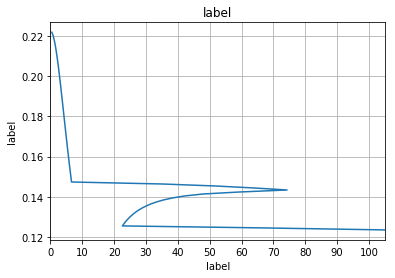

In [6]:
import matplotlib.pyplot as plt
plt.plot(offset, rayParameters) # Plot ray-parameter as a function of offset
plt.ylabel('label') # TODO - put an appropriate label here
plt.xlabel('label') # TODO - put an appropriate label here
plt.title('label')  # TODO - put an appropriate title here
plt.xlim(0,max(offset))
plt.xticks(linspace(0,100,11))
plt.grid(True)
plt.show()

WRITE YOUR ANSWER HERE


# Depth Phases and Event Depth Estimation

The ability to predict travel time as a function of distance is useful for a variety of tasks.  One particularly important task is to locate earthquakes in $1D$ models.  Here we will use as a-priori information the event epicenter and optimize for the a depth and origin time.  At teleseismic distances, like in local events, we face a trade-off.  This trade-off is that we could decrease the event depth by decreasing the origin-time.  A way to eliminate this trade-off is to use depth phases that first travel up from the source and then reflect onto receiver location thereby emplacing a constraint on the depth.  For this activity we'll get some data from a deep earthquake in Alaska that has $P$ phases and $pP$ depth phases.  Then, we will generate theoretical times using a global theoretical travel time table.  Finally, we will tabulate an objective function and see how depth and origin time trade-off at teleseismic distances with $P$ phases and with $P$ phases and $pP$ phases.


## Data

Here we will use data collected by some broadband Pacific Northwest Seismic Network stations.  The information we extract is an estimate of the phase arrival time, or a travel time *pick*.  


In [7]:
# If using Anaconda3 on your machine you can do without this.  This is for Azure people.
#!pip install obspy # TODO Uncomment if on Azure

In [8]:
# A relatively deep earthquake in Alaska
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from obspy.geodetics.base import gps2dist_azimuth
from obspy import read
from obspy import Stream
from obspy.signal.trigger import recursive_sta_lta # Help with picking
from obspy.signal.trigger import plot_trigger      # Visualizing what the picker
from obspy.taup import TauPyModel # This will let us compute global travel times
from numpy import meshgrid # Plotting stuff
from numpy import sqrt
import matplotlib.cm as cm

# Initialize some obspy things
model = TauPyModel(model="ak135") # For computing travel times
client = Client("IRIS")
# Pull waveforms BC earthquake from https://earthquake.usgs.gov/earthquakes/eventpage/us2000b2vq#executive
originTime = UTCDateTime("2017-10-08T22:34:33")
eventLat = 52.391   # Event latitude from catalog
eventLon =-176.769  # Event longitude from catalog
eventDepth = 119.0  # Event depth from catalog

def getStationLocation(network="IU", station="KEV", channel="BHZ", location="00"):
    """
    A convenience function for getting the station latitude and longitude from the given station, network,
    channel, and location.
    
    Returns
    stationLatitude : float
       Station latitude in degrees.
    stationLongitude : float
       Station longitud in degrees.
    """
    # It's much more convenient to wildcard and get ZNE all at once
    stRaw = client.get_waveforms(network, station, location, channel, originTime, originTime+3000) #t, t + 60 * 60)
    # Very awkward - but get the station lat/lon (I don't why obspy isn't lifting this from the miniSEED header)
    inventory = client.get_stations(network=network, station=station,
                                    starttime=originTime, endtime=originTime+400)
    for net in inventory:
        for sta in net:
            stationLatitude = sta.latitude
            stationLongitude = sta.longitude
            return stationLatitude, stationLongitude
    print("Error getting station location")
    return None, None

# Pull data from some puget sound stations
windowStart = 410
windowEnd   = windowStart + 70
nets     = ["UW",  "UW",  "UW",   "UW",   "UW"]
stations = ["GNW", "SP2", "RATT", "DOSE", "TOLT"]
channels = ["BHZ", "BHZ", "BHZ",  "BHZ",  "BHZ"]
locs     = ["--",  "--",  "--",   "--",   "--"]
# Get the data
dataList = []
for k in range(len(nets)):
    # Fetch the waveform data
    st = client.get_waveforms(nets[k], stations[k], locs[k],  channels[k], 
                              originTime + windowStart, originTime + windowEnd, attach_response=True)[0]
    # Fetch the station lat/lon
    stla, stlo = getStationLocation(network=nets[k], station=stations[k], channel=channels[k], location=locs[k])
    # Compute the dsitance
    d, az, baz = gps2dist_azimuth(eventLat, eventLon, stla, stlo)
    distDeg = d*1.e-3/111.195
    st.stats.coordinates = {'latitude': stla, 'longitude': stlo, 'distance': distDeg}
    # Append the data to the data list
    dataList.append(st)
# Make an obspy stream 
data = Stream(traces=dataList)


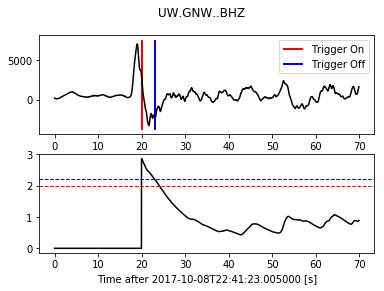

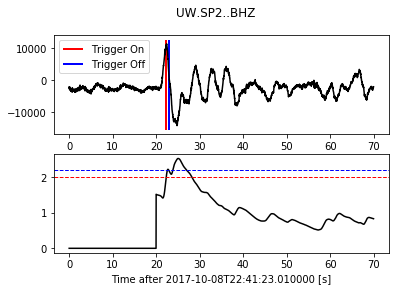

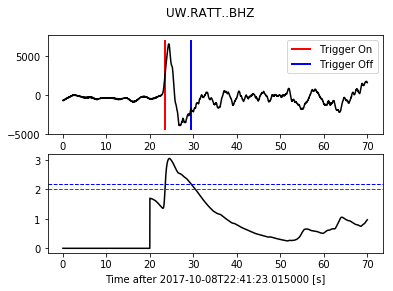

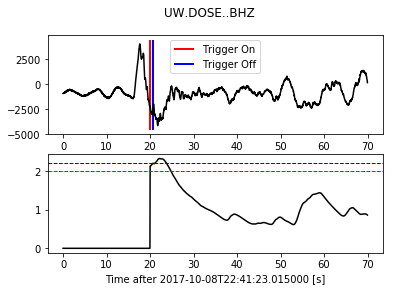

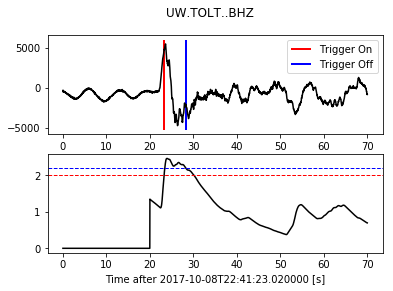

In [9]:
# Plot the picks and get my attention use an automatic picker
for k in range(len(data)):
    cft = recursive_sta_lta(data[k].data, int(6 * data[k].stats.sampling_rate), int(20* data[k].stats.sampling_rate))
    #plot_trigger(data[k].data, cft, 1.2, 0.5)
    plot_trigger(data[k], cft, 2., 2.2)

In [10]:
# Call these the pick times
from numpy import array
# Create an array of observed arrival times.  Recall I'm requesting waveforms windowStart seconds after the
# catalog origin time so I need to add that back in for the full pick time.
observed_P_times  = array([18, 22, 24, 16, 22]) + windowStart - 35.0 # I think NEIC's origin time is screwy
observed_pP_times = array([52, 56, 52, 48, 52]) + windowStart - 35.0 # Or it's possible ObsPy is grabbing waveforms awkwardly
print("The observed P pick times are:", observed_P_times, "seconds")
print("The observed pP pick times are:", observed_pP_times, "seconds")

The observed P pick times are: [ 393.  397.  399.  391.  397.] seconds
The observed pP pick times are: [ 427.  431.  427.  423.  427.] seconds


In [11]:
def getPhasePickTime(eventLat, eventLon, eventDepth, stationLat, stationLon, phaseName=['P']):
    """
    Convenience function to get the desired phase pick time from the ak135 travel time table.
    
    Input
    -----
    eventLat : float
       Event latitude in degrees
    eventLon : float
       Event longitude in degrees
    eventDepth : float
       Event depth in degrees
    stationLat : float
       Station latitude in degrees
    stationLon : float
       Station longitude in degrees
    phaseName : list
       Phase name - e.g., ['P'] for a P phase or ['pP'] for a P depth phase.
    
    Result
    ------
    phaseTime : float
       Theoretical travel time for phase in seconds
    
    Copyright
    ---------
    Ben Baker distributed under the MIT license.
    
    """
    # Compute the source/receiver distance in meters
    d, az, baz = gps2dist_azimuth(eventLat, eventLon, stationLat, stationLon)
    # Convert kilometers to degrees where 111.195 is the number of kilometers per degree
    distDeg = d*1.e-3/111.195 # Convert to kilometers then to degrees
    # Compute the travel time for the phase - for example look at Figure 4.20 of Shearer
    pArrival = model.get_travel_times(source_depth_in_km=eventDepth,
                                      distance_in_degree=distDeg,
                                      phase_list=phaseName) #["P"])
    return pArrival[0].time

# This is some debugging code   
#k = 0
#for k in range(len(data)):
#    stationLat = data[k].stats.coordinates.latitude
#    stationLon = data[k].stats.coordinates.longitude
#    P_time  = getPhasePickTime(eventLat, eventLon, eventDepth, stationLat, stationLon, phaseName=['P'])
#    pP_time = getPhasePickTime(eventLat, eventLon, eventDepth, stationLat, stationLon, phaseName=['pP'])
#    #print(P_time, pP_time, pP_time - P_time)

## Algorithm

Now that we've made observed travel time picks and can make theoretical picks we will tabulate an objective functions for each candidate origin time, $t_0$ and depth $d$ as the residual squared of the observed and estimate travel times for the $P$ phase only
\begin{equation}
  \mathcal{C}_{P}(t_0,d)
 =\sum_{i=1}^{n_{obs}} (P_i^{obs}  - P_i^{est}(d, \Delta_i) + t_0)^2
\end{equation}
and the combined $P$ and $pP$ phases 
\begin{equation}
  \mathcal{C}_{pP}(t_0,d)
 =\sum_{i=1}^{n_{obs}} (P_i^{obs}  - P_i^{est}(d, \Delta_i) + t_0)^2
                     + (pP_i^{obs} - pP_i^{est}(d, \Delta_i) + t_0)^2
\end{equation}
Here $i$ is the observation counter and $\Delta_i$ the great-circle distance between the source and i'th observation.

In [12]:
# Now we have the observed the estimate pick times - let's make an objective function.  To do this, let's 
# grid search over candidate depths from 80 - 160 and origin times from [-20s, 20s]
nobs = len(data) 
nt = 31
nd = 81
relativeOriginTime = linspace(-30, 30, nt)
depths = linspace(60, 180, nd)
# Build up a travel time table at each depth and distance distance 
print("Computing travel times...")
P_travelTimeTable = zeros([nd, nobs])
pP_travelTimeTable = zeros([nd, nobs])
for idep in range(nd):
    for iobs in range(nobs):
        # Compute the P theoretical travel time at this event depth/station distance
        stationLat = data[k].stats.coordinates.latitude
        stationLon = data[k].stats.coordinates.longitude
        P_travelTimeTable[idep, iobs] = getPhasePickTime(eventLat, eventLon, depths[idep], 
                                                        stationLat, stationLon, phaseName=['P'])
        # Compute the pP theoretical travel time at this event depth/station distance
        pP_travelTimeTable[idep, iobs] = getPhasePickTime(eventLat, eventLon, depths[idep], 
                                                         stationLat, stationLon, phaseName=['pP'])
    # Loop on observations
# Loop on depths
print("Tabulating objective function...")
# Now tabulate two objective functions.  The first objective function
sumResidualsSquared_P_phase = zeros([nt, nd])
sumResidualsSquared_pPandP_phase = zeros([nt, nd])
for idep in range(nd):
    for it in range(nt):
        P_estimate  = P_travelTimeTable[idep,:]  + relativeOriginTime[it] # P estimate travel time
        pP_estimate = pP_travelTimeTable[idep,:] + relativeOriginTime[it] # pP estimate travel time 
        # Tabulate the residuals
        P_residuals   = observed_P_times  - P_estimate
        pP_residuals  = observed_pP_times - pP_estimate
        # Compute the sum squared of the residuals
        sumResidualsSquared_P_phase[it, idep]      = sum(P_residuals**2)
        sumResidualsSquared_pPandP_phase[it, idep] = sum(P_residuals**2) + sum(pP_residuals**2)
    # Loop on travel times
# Loop on depths
# Compute the square root of the objective functions to make them l2 norms
sumResidualsSquared_P_phase = sqrt(sumResidualsSquared_P_phase)
sumResidualsSquared_pPandP_phase = sqrt(sumResidualsSquared_pPandP_phase)

Computing travel times...
Tabulating objective function...


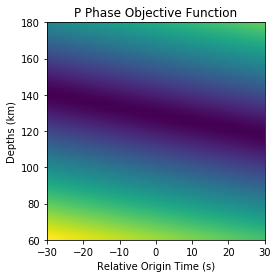

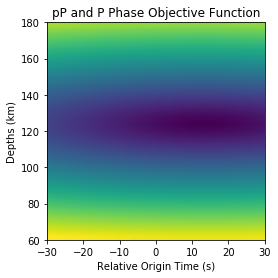

In [13]:
# Plot the results
[X, Y] = meshgrid(relativeOriginTime, depths)
extent = [min(relativeOriginTime), max(relativeOriginTime), min(depths), max(depths)]
im = plt.imshow(sumResidualsSquared_P_phase, interpolation='bilinear', cmap=cm.viridis,  
                extent=extent, aspect=1./2.)
plt.title("P Phase Objective Function")
plt.xlabel('Relative Origin Time (s)')
plt.ylabel('Depths (km)')
plt.show()

im = plt.imshow(sumResidualsSquared_pPandP_phase, interpolation='bilinear', cmap=cm.viridis, 
                extent=extent, aspect=1/2.)
plt.title("pP and P Phase Objective Function")
plt.xlabel('Relative Origin Time (s)')
plt.ylabel('Depths (km)')
plt.show()


## Question

In this color scheme dark-blue is good and bright yellow is bad.  Which plot shows a clear trade-off with origin time and depth?

## Question

If the hypocenter of an earthquake observed at teleseismic distances only included $P$ primary phases in the inversion - would you have high-confidence in the recovered depth parameter?

## Question

At local distances we see the same trade-off with origin time and depth.  Can you identify a phase in a regional network like the PNSN that would help to resolve this depth/origin time ambiguity?  Note that all-phases leave upwards from the source so depth-phases are not a valid option.
